In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Market Basket Analysis

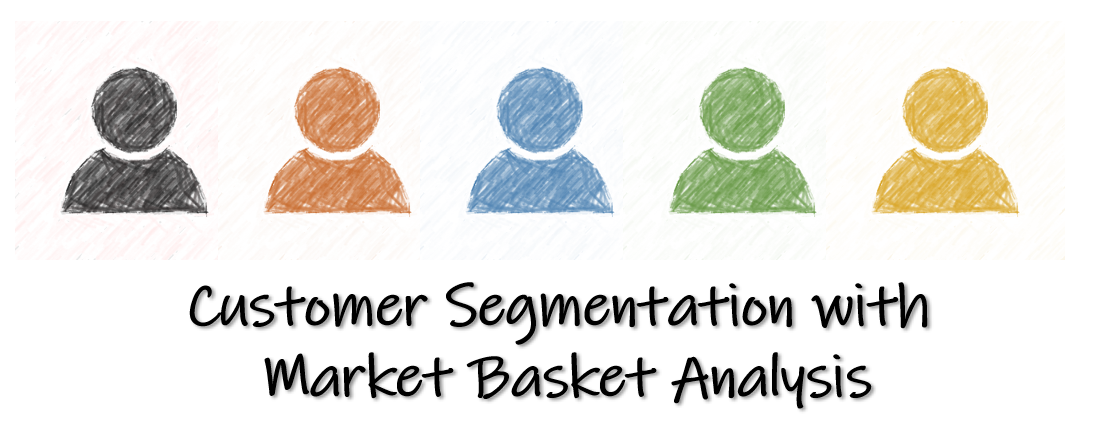

**Import libraries**

In [ ]:
import pandas as pd
import pandas_profiling as pp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import networkx as nx

In [ ]:
import warnings
warnings.filterwarnings("ignore")

**Import data**

In [ ]:
dat = pd.read_csv("../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

**Exploratory data analysis (EDA)**

In [ ]:
dat.info()

In [ ]:
dat.describe()

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
dat.plot(kind='hist',ax=ax, subplots=True, bins=40)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
dat.groupby("Gender").CustomerID.agg('count').plot(kind='barh',ax=ax).set_title('Count by gender')
plt.grid()

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20, 5))
sdat = dat.groupby(by='Gender')
sdat.get_group("Male").plot(kind='hist',ax=ax, subplots=True, bins=40)

In [ ]:
sns.pairplot(sdat.get_group("Male")).fig.set_size_inches(15,15)

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20, 5))
sdat = dat.groupby(by='Gender')
sdat.get_group("Female").plot(kind='hist',ax=ax, subplots=True, bins=40)

In [ ]:
sns.pairplot(sdat.get_group("Female")).fig.set_size_inches(15,15)

In [ ]:
mask = np.triu(np.ones_like(dat.corr(), dtype=bool))
sns.heatmap(dat.corr(),mask=mask,cmap='Spectral',vmin=-1,vmax=1)

In [ ]:
dat.columns

In [ ]:
sns.scatterplot(data=dat,x='Age',y='Annual Income (k$)',hue='Gender',size='Spending Score (1-100)')
fig = plt.gcf()
fig.set_size_inches(20,5)

In [ ]:
sns.scatterplot(data=dat,x='Age',size='Annual Income (k$)',hue='Gender',y='Spending Score (1-100)')
fig = plt.gcf()
fig.set_size_inches(20,5)

In [ ]:
sns.scatterplot(data=dat,size='Age',x='Annual Income (k$)',hue='Gender',y='Spending Score (1-100)')
fig = plt.gcf()
fig.set_size_inches(20,5)

In [ ]:
sns.jointplot(x=dat.Age, y=dat['Annual Income (k$)'],kind='hex')
fig = plt.gcf()
fig.set_size_inches(6,6)

In [ ]:
sns.jointplot(x=dat['Annual Income (k$)'],y = dat['Spending Score (1-100)'],kind='hex')
fig = plt.gcf()
fig.set_size_inches(6,6)

In [ ]:
# pp.ProfileReport(dat)

**Scale the data**

In [ ]:
df = dat.copy()
df.drop(axis=1,columns='CustomerID',inplace=True)
df['IsMale'] = 1
df.loc[df[df.Gender == "Female"].index,'IsMale'] = 0
df.drop(axis=1, columns='Gender',inplace=True)
df.head()

In [ ]:
df.describe()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scal = MinMaxScaler()
temp = scal.fit_transform(df)
dfscal = pd.DataFrame(temp,columns=df.columns, index=df.index)
dfscal.head()

**Clustering**

In [ ]:
cdf = dfscal.copy()

In [ ]:
inertia = []
for icluster in range(1,11):
    clust = KMeans(n_clusters=icluster, n_init=10, max_iter=300, tol=1e-3, random_state=0)
    clust.fit(cdf)
    inertia.append(clust.inertia_)
    
sns.lineplot(x=range(1,11), y=inertia)
plt.grid()

# optimal number of clusters with approximate slope 135 degrees, n = 5

In [ ]:
clust = KMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-3, random_state=0)
clust.fit(cdf)
cdf['Labels_'] = clust.labels_
centroids = clust.cluster_centers_

In [ ]:
dfscal.head()

In [ ]:
df.head()

In [ ]:
cdf.head()

In [ ]:
import matplotlib as mp
cmap = mp.cm.cool
sns.scatterplot(data=cdf,size='Age',x='Annual Income (k$)',hue='Labels_',y='Spending Score (1-100)',style='IsMale',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)

In [ ]:
np.random.seed(0)

In [ ]:
def jitter(x):
    if x < 0.5:
        x = x + np.random.random()*0.45
    else:
        x = x - np.random.random()*0.45
    return x
            
cdf['JitterIsMale'] = cdf['IsMale']
cdf['JitterIsMale'] = cdf['JitterIsMale'].apply(jitter)

In [ ]:
def bin_column(x):
    # note that this assumes scaled columns
    nbin = 4
    bd = np.linspace(0,1,nbin+1)
    for i, nbd in enumerate(bd):
        if x < nbd:
            return i
            
cdf['BinIncome'] = cdf['Annual Income (k$)'].apply(bin_column)

In [ ]:
cdf.sample(10)

In [ ]:
sns.scatterplot(data=cdf,size='Age',x='JitterIsMale',hue='Labels_',y='Spending Score (1-100)',style='BinIncome',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)
fig.axes[0].add_patch(mp.patches.Rectangle((0,0),0.5,1,fill=True,facecolor='gray',alpha=0.1))
fig.axes[0].add_patch(mp.patches.Rectangle((0.5,0),0.5,1,fill=True,facecolor='green',alpha=0.1))
plt.text(0.25,1.01,"Female")
plt.text(0.75,1.01,"Male")
plt.gca().set_xticks([])
plt.legend()
plt.show()

**Dimension reduction**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
cdf.columns

In [ ]:
dimred_df = cdf.copy()
dimred_df.drop(columns=['Labels_', 'JitterIsMale', 'BinIncome'], inplace=True)
pca = PCA(n_components=4)
pca.fit_transform(dimred_df)
plt.plot(np.arange(1,5),np.cumsum(pca.explained_variance_ratio_),'o-')
plt.ylabel("Explained variance")
plt.xlabel("Number of components")
plt.grid()

In [ ]:
dimred_df.sample(5)

In [ ]:
pca = PCA(n_components=4)
pca_dat = pca.fit_transform(dimred_df)

In [ ]:
pca_inertia = []
for icluster in range(1,11):
    clust = KMeans(n_clusters=icluster, n_init=10, max_iter=300, tol=1e-3, random_state=0)
    clust.fit(pca_dat)
    pca_inertia.append(clust.inertia_)
    
sns.lineplot(x=range(1,11), y=pca_inertia)
plt.grid()

In [ ]:
clust = KMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-3, random_state=0)
clust.fit(pca_dat)
pca_df = pd.DataFrame(pca_dat, index=df.index, columns=['Comp1','Comp2','Comp3','Comp4'])
pca_df['Labels_'] = clust.labels_

In [ ]:
pca_df.head()

In [ ]:
sns.scatterplot(data=pca_df,size='Comp3',x='Comp1',hue='Labels_',y='Comp2',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.legend('')

Based on the analysis, Gender and spending score is sufficent for clustering.

**Testing hypothesis**

In [ ]:
test_df = cdf.copy()
test_df.drop(inplace=True,columns=['Age', 'Annual Income (k$)', 'Labels_', 'JitterIsMale', 'BinIncome'])
clust = KMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-3, random_state=0)

clust.fit(test_df)
test_df['Labels_'] = clust.labels_

In [ ]:
test_df.sample(5)

In [ ]:
sns.scatterplot(data=test_df,y='Spending Score (1-100)',hue='Labels_',x='IsMale',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)